# Práctica Background Subtraction

En esta segunda práctica del bloque de análisis de secuencias haremos trabajo con 3 técnicas de background subtraction.

En primer lugar debéis implementar vuestro propio método de eliminación de fondo basado en la idea que explicamos del filtro exponencial. Podéis hacer las adaptaciones que encontréis necesario a la idea general del método para mejorar su rendimiento.

En segundo lugar debéis de usar las implementaciones del MOG y del MOG2 que se encuentran en la librería
 [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html).

En tercer lugar lo que quiero es que hagáis una comparativa entre su método y los dos basados en Mixture de gausiano utilizando el dataset de la competición [changedetection.net](http://changedetection.net/) del año 2012.

En concreto debe usar una secuencia de cada categoría exceptuando la de *Thermal*.

Las métricas que a usar para cada secuencia son:

* **TP** : True Positive
* **FP** : False Positive
* **FN** : False Negative
* **TN** : True Negative
* **Re (Recall)** : TP / (TP + FN)
* **F-Measure** : (2 * Precision * Recall) / (Precision + Recall)
* **Precision** : TP / (TP + FP)

Finalmente se pide que hagáis un análisis de los resultados obtenidos por cada secuencia: problemas, carencias, puntos fuertes de los algoritmos ...

**Entrega:**

* Explicación del algoritmo implementado y código fuente.
* Resultados de las secuencias en formato imagen o video.
* Resultados de las secuencias en formato tabla resumen de las métricas.
* Análisis de los resultados

### Funciones auxiliares para calculo de métricas

In [1]:
def recall(tp, fn):
    return (tp/(tp+fn))

def precision(tp, fp):
    return (tp/(tp+fp))

def f_measure(precision, recall):
    return ((2*precision*recall)/(precision+recall))


def all_metrics (resultPath, groundtruthPath, start_frame, end_frame):
    # Cargamos el resultado del filtro indicado
    result = loadImages(resultPath)
    groundTruth = loadImages(groundtruthPath)
    
    # ground truth empieza en start_frame, los frames están numerados de 1 hasta n, pero el array de frames va de 0 a n-1
    total_frames = end_frame-start_frame

    # Inicializamos un array para cada métrica donde se el resultado para cada frame
    tp =  np.zeros(total_frames)
    fp =  np.zeros(total_frames)
    fn =  np.zeros(total_frames)
    tn =  np.zeros(total_frames)

    # Calculamos las métricas True Positive, False Positive, False Negative, True Negative para cada frame
    for i in range(total_frames):
        tp[i], fp[i], fn[i], tn[i] = comparator(result[i+start_frame], groundTruth[i+start_frame])

    # Calculamos las métricas Recall, Precision y F-measure para cada frame    
    recall_frame = recall(tp=tp, fn=fn)
    precision_frame = precision(tp=tp, fp=fp)
    fMeasure_frame = f_measure(precision=precision_frame, recall=recall_frame)

    # Calculamos las métricas anteriores para toda la secuencia en conjunto
    tp_secuencia = tp.sum()
    fp_secuencia = fp.sum()
    fn_secuencia = fn.sum()
    tn_secuencia = tn.sum()

    recall_secuencia = recall(tp=tp_secuencia, fn=fn_secuencia)
    precision_secuencia = precision(tp=tp_secuencia, fp=fp_secuencia)
    fMeasure_secuencia = f_measure(precision=precision_secuencia, recall=recall_secuencia)
    
    cm_frames = np.array([tp,fp,fn,tn])
    cm_secuencia = np.array ([tp_secuencia, fp_secuencia, fn_secuencia, tn_secuencia])
    
    r_p_fm_frames = np.array([recall_frame, precision_frame, fMeasure_frame])
    r_p_fm_secuencia = np.array([recall_secuencia, precision_secuencia, fMeasure_secuencia])
    
    return cm_frames, cm_secuencia, r_p_fm_frames, r_p_fm_secuencia

### Filtro exponencial para _background subtraction_
Parte de la idea de eliminación de fondo más básica: restar el fotograman **_fondo_** (_background_) del fotograma actual para obtener el **_primer plano_** (_foreground_).  
El primer problema para realizar este algoritmo es conseguir ese fotograma **_fondo_**. Para ello se necesita una imagen que represente el fondo sin ningún otro objeto, pero esto no siempre es posible, por lo tanto hay que buscar otras soluciones. Una de ellas es estimar el fondo como la media o la mediana a partir de los primeros _n_ fotogramas.  
El segundo problema que surge es que el fondo en los casos prácticos varía con el tiempo y por lo tanto es posible que ese fotograma _fondo_ que hemos estimado no nos sirve más tarde. Por lo tanto la mejora que se propone es estimar el fondo recursivamente respecto el fotograma anterior siguiendo la siguiente fórmula: 
$$
\begin{align}
B_t=(1-{\alpha})B_{t-1}+{\alpha}I_t
\end{align}
$$
Donde $B_t$ es la estimación del fondo para el fotograma actual, $B_{t-1}$ es el fondo para el fotograma anterior, $I_t$ es el fotograma actual y $\alpha$ es el factor de aprendizaje que indica cuánto del fotograma actual se considerará fondo para el siguiente fotograma.

In [2]:
from utils import *
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

Para mantener la limpieza del _notebook_, se han definidos una serie de funciones para realizar el análisis y la aplicación de los algoritmos dentro del archivo _utils.py_.      
Las funciones que se encuentran son las siguientes:
- **comparator**: compara un _frame_ resultante de un modelo de _background subtraction_ con el resultado esperado (_groundtruth_)
- **loadImages**: devuelve una lista con las imágenes dentro de la carpeta especificada
- **exponentialFilter**: implementación del algoritmo basado en filtro exponencial
- **MOG**: implementación del algoritmo MOG disponible [aquí](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html)
- **MOG2**: implementación del algoritmo MOG2 disponible [aquí](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html)
- **im2vid**: genera video a partir de las imágenes ubicadas en una carpeta
- **showVideo**: muestra el video en una ventana flotante para visualizar mejor el resultado del modelo

Notar que, a pesar de tratarse de algoritmos que trabajan con video, el _dataset_ que se proporciona para realizar las pruebas son imágenes que representan los fotogramas de una secuencia. Por lo tanto, las funciones que se han realizado, se han pensado para trabajar con imágenes en vez de video.

# 1. Secuencia _highway_ del dataset _baseline_

Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [3]:
# baseline highway dataset groundtruth y input paths
gt_highway_path = 'DATA/baseline/baseline/highway/groundtruth/*.png'
in_highway_path = 'DATA/baseline/baseline/highway/input/*.jpg'

groundTruth = loadImages(gt_highway_path)
frames = loadImages(in_highway_path)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1700/1700 [00:02<00:00, 794.24it/s]


## 1.1. Algoritmo filtro exponencial

Aplicamos el algoritmo basado en el filtro exponencial que hemos implementado.

In [4]:
# baseline highway dataset output path
expFilter_highway_path = 'DATA/baseline/results/highway/expFilter/'

exponentialFilter(frames, 0.3, expFilter_highway_path, 20, bgFilter ='MEDIAN')

Algorithm application: 100%|█████████████████████████████████████████████████████| 1680/1680 [00:01<00:00, 1112.92it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [5]:
im2vid(expFilter_highway_path+'*.png','expFilter_highway.mp4')
# Descomentar la siguiente línea para mostrar el video durante la ejecución
#showVideo('expFilter_highway.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 2750/2750 [00:01<00:00, 2018.55it/s]


### 1.1.1. Cálculo de métricas
Calculamos las métricas comparando con el _ground truth_ propocionado. Para cada secuencia se proporciona una ROI (Region Of Interest) sobre la cual se realiza el groundtruth, para simplificar el cálculo se han seleccionado aquellas secuencias en las que la ROI sea toda la imagen. Por otro lado, también se especifica el _frame_ de inicio y final sobre los que se ha de realizar la verificación del algoritmo, por lo tanto solo se calcularán las métricas dentro de ese rango. Tampoco se tiene en cuenta la clasificación de sombras, se considera como clasificación correcta tanto si se clasifica como fondo como _background_ como _foreground_.

In [6]:
cm_frames_EF,\
cm_secuencia_EF,\
r_p_fm_frames_EF,\
r_p_fm_secuencia_EF = all_metrics (expFilter_highway_path+'*.png', gt_highway_path, start_frame=469, end_frame=1699)

Loading images: 100%|████████████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 2626.41it/s]


## 1.2. Algoritmo MOG

Aplicamos el algoritmo MOG (Mixture Of Gaussians)

In [7]:
# baseline highway dataset output path
MOG_highway_path = 'DATA/baseline/results/highway/MOG/'

MOG(frames,MOG_highway_path)

Algorithm application2: 100%|█████████████████████████████████████████████████████| 1700/1700 [00:03<00:00, 494.94it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [8]:
im2vid(MOG_highway_path+'*.png','MOG_highway.mp4')
# Descomentar la siguiente línea para mostrar el video durante la ejecución
#showVideo('MOG_highway.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 3689.26it/s]


### 1.2.1. Cálculo de métricas

In [9]:
cm_frames_MOG,\
cm_secuencia_MOG,\
r_p_fm_frames_MOG,\
r_p_fm_secuencia_MOG = all_metrics (MOG_highway_path+'*.png', gt_highway_path, start_frame=469, end_frame=1699)

Loading images: 100%|████████████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 2651.48it/s]


## 1.3. Algoritmo MOG2

In [10]:
# baseline highway dataset output path
MOG2_highway_path = 'DATA/baseline/results/highway/MOG2/'

MOG2(frames,MOG2_highway_path)

Algorithm application: 100%|██████████████████████████████████████████████████████| 1700/1700 [00:03<00:00, 444.31it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [8]:
im2vid(MOG2_highway_path+'*.png','MOG2_highway.mp4')
# Descomentar la siguiente línea para mostrar el video durante la ejecución
#showVideo('MOG2_highway.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 3689.26it/s]


### 1.3.1. Cálculo de métricas

In [11]:
cm_frames_MOG2,\
cm_secuencia_MOG2,\
r_p_fm_frames_MOG2,\
r_p_fm_secuencia_MOG2 = all_metrics (MOG2_highway_path+'*.png', gt_highway_path, start_frame=469, end_frame=1699)

Loading images: 100%|████████████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 2642.72it/s]


## Comparación resultados

Obtenemos también las métricas para el _ground truth_ para poder comparar los valores TP, FP, FN y TN

In [12]:
cm_frames_gt,\
cm_secuencia_gt,\
r_p_fm_frames_gt,\
r_p_fm_secuencia_gt = all_metrics (gt_highway_path, gt_highway_path, start_frame=469, end_frame=1699)

Loading images: 100%|████████████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 2659.19it/s]


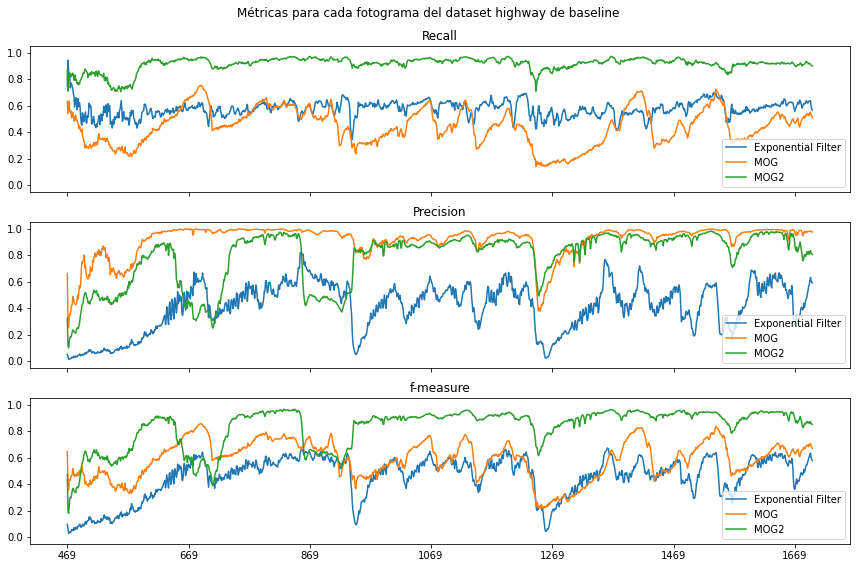

In [13]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(12,8))
ax[0].plot(r_p_fm_frames_EF[0], label="Exponential Filter")
ax[0].plot(r_p_fm_frames_MOG[0],label="MOG")
ax[0].plot(r_p_fm_frames_MOG2[0],label="MOG2")
ax[0].set_title("Recall")

locs, labels = plt.xticks()
my_ticks = np.zeros(len(locs))
for i in range(len(locs)):
    my_ticks[i] = int(locs[i]+469)
    
my_ticks = my_ticks.astype(int)

plt.xticks(locs[1:-1], my_ticks[1:-1])


ax[1].plot(r_p_fm_frames_EF[1],label="Exponential Filter")
ax[1].plot(r_p_fm_frames_MOG[1],label="MOG")
ax[1].plot(r_p_fm_frames_MOG2[1],label="MOG2")
ax[1].set_title("Precision")
plt.xticks(locs[1:-1], my_ticks[1:-1])

ax[2].plot(r_p_fm_frames_EF[2],label="Exponential Filter")
ax[2].plot(r_p_fm_frames_MOG[2],label="MOG")
ax[2].plot(r_p_fm_frames_MOG2[2],label="MOG2")
ax[2].set_title("f-measure")
plt.xticks(locs[1:-1], my_ticks[1:-1])



plt.ylim([-0.05,1.05])
legend = ax[0].legend(loc='lower right')
legend = ax[1].legend(loc='lower right')
legend = ax[2].legend(loc='lower right')
fig.suptitle('Métricas para cada fotograma del dataset highway de baseline')
fig.tight_layout()
plt.show()

En la gráfica anterior se observa las medidas de Recall, Precision y f-measure para los 3 algoritmos. El comportamiento del MOG y MOG2 es bastante similar, en general MOG2 es mejor que MOG exceptuando en el caso de la Precision. El filtro exponencial para la medida de Recall se comporta mejor que MOG para la mayoría de los casos, esto es posible ya que el algoritmo implementado es más sensible que MOG y acierta clasificando como _foreground_ en más ocasiones que MOG.

In [14]:
EF_result = loadImages(expFilter_highway_path+'*.png')
MOG_result = loadImages(MOG_highway_path+'*.png')
MOG2_result = loadImages(MOG2_highway_path+'*.png')

Loading images: 100%|████████████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 1984.25it/s]


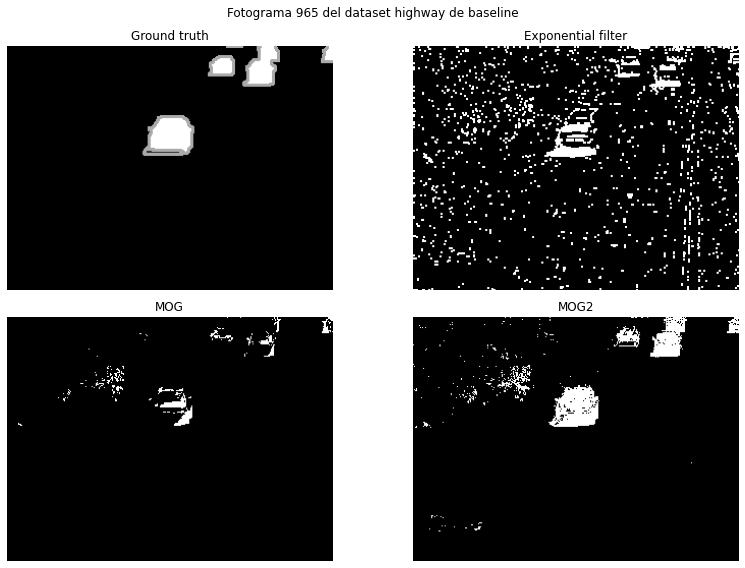

In [15]:
frame = 964
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,8))
ax[0,0].imshow(groundTruth[frame])
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')

ax[0,1].imshow(EF_result[frame])
ax[0,1].axis('off')
ax[0,1].set_title('Exponential filter')


ax[1,0].imshow(MOG_result[frame])
ax[1,0].axis('off')
ax[1,0].set_title('MOG')

ax[1,1].imshow(MOG2_result[frame])
ax[1,1].axis('off')
ax[1,1].set_title('MOG2')


fig.suptitle('Fotograma '+ str(frame+1) + ' del dataset highway de baseline')
fig.tight_layout()
plt.show()

En la figura anterior se compara el comportamiento de los diferentes algoritmos para el fotograma 965. En este momento, se puede observar en las gráficas que la precision y la f-measure disminuye drásticamente. Esto se debe a que, sobre todo, el algoritmo basado en filtro exponencial detecta mucho ruido como _foreground_ en vez de fondo. Se ve también que MOG es el que menos ruido detecta a costa de detectar muy poco a los coches.  
Por otro lado, en el caso del filtro exponencial, en los videos, se observa que los vehículos dejan una cola tras de sí, si se aumentará el ratio de aprendizaje del algoritmo se podría conseguir disminuir. En el caso de MOG y MOG2 esta cola es imperceptible.

Guardamos en un _dataframe_ los resultados obtenidos para esta secuencia

In [16]:
df_highway = pd.DataFrame(np.array([np.concatenate((r_p_fm_secuencia_EF,cm_secuencia_EF)),
                                    np.concatenate((r_p_fm_secuencia_MOG,cm_secuencia_MOG)),
                                    np.concatenate((r_p_fm_secuencia_MOG2,cm_secuencia_MOG2)),
                                    np.concatenate((r_p_fm_secuencia_gt,cm_secuencia_gt))]),
                         columns = ['Recall', 'Precision','F-measure','TP','FP','FN','TN'])
df_highway['Algorithm'] = ['Exponential Filter','MOG','MOG2','Ground truth']
df_highway.set_index('Algorithm')

,Recall,Precision,F-measure,TP,FP,FN,TN
Algorithm,,,,,,,
Exponential Filter,0.590599,0.434918,0.500942,4165508.0,5412167.0,2887516.0,81998809.0
MOG,0.500938,0.967187,0.660027,3156445.0,107085.0,3144618.0,88055852.0
MOG2,0.933806,0.774233,0.846565,6843616.0,1995606.0,485117.0,85139661.0
Ground truth,1.000000,1.000000,1.000000,5448641.0,0.0,0.0,86228220.0


En la tabla resumen anterior, se puede comprobar que efectivamente, MOG2 es el que mejor resultado da en general a excepción de la precision que se obtiene mejor resultado con MOG. Por lo tanto, teniendo en cuenta estos resultados, el algoritmo MOG nos proporcionará mejores resultados que MOG2 en entornos con ruido.

# 2. Secuencia _badminton_ del dataset _cameraJitter_

Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [17]:
#camaraJitter  badminton dataset input
gt_badminton_path = 'DATA/cameraJitter/cameraJitter/badminton/groundtruth/*.png'
in_badminton_path = 'DATA/cameraJitter/cameraJitter/badminton/input/*.jpg'

groundTruth = loadImages(gt_badminton_path)
frames = loadImages(in_badminton_path)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1150/1150 [00:03<00:00, 301.32it/s]


## 2.1. Algoritmo filtro exponencial

In [18]:
# camaraJitter badminton dataset output path
expFilter_badminton_path = 'DATA/cameraJitter/results/badminton/expFilter/'

exponentialFilter(frames, 0.3, expFilter_badminton_path, 20, bgFilter ='MEDIAN')

Algorithm application: 100%|██████████████████████████████████████████████████████| 1130/1130 [00:06<00:00, 184.78it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [19]:
im2vid(expFilter_badminton_path+'*.png','expFilter_badminton.mp4')
#showVideo('expFilter_badminton.mp4')

Converting to video: 100%|████████████████████████████████████████████████████████| 1150/1150 [00:03<00:00, 335.78it/s]


### 2.1.1. Cálculo de métricas

In [20]:
cm_frames_EF,\
cm_secuencia_EF,\
r_p_fm_frames_EF,\
r_p_fm_secuencia_EF = all_metrics (expFilter_badminton_path+'*.png', gt_badminton_path, start_frame=799, end_frame=1149)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1150/1150 [00:01<00:00, 766.68it/s]


## 2.2. Algoritmo MOG

In [21]:
# camaraJitter badminton dataset output paths
MOG_badminton_path = 'DATA/cameraJitter/results/badminton/MOG/'

MOG(frames, MOG_badminton_path)

Algorithm application2: 100%|█████████████████████████████████████████████████████| 1150/1150 [00:09<00:00, 115.33it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [22]:
im2vid(MOG_badminton_path+'*.png','MOG_badminton.mp4')
#showVideo('MOG_badminton.mp4')

Converting to video: 100%|████████████████████████████████████████████████████████| 1150/1150 [00:01<00:00, 752.17it/s]


### 2.2.1. Cálculo de métricas

In [23]:
cm_frames_MOG,\
cm_secuencia_MOG,\
r_p_fm_frames_MOG,\
r_p_fm_secuencia_MOG = all_metrics (MOG_badminton_path+'*.png', gt_badminton_path, start_frame=799, end_frame=1149)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1150/1150 [00:01<00:00, 754.63it/s]


## 2.3. Algoritmo MOG2

In [24]:
# camaraJitter badminton dataset output paths
MOG2_badminton_path = 'DATA/cameraJitter/results/badminton/MOG2'

MOG2(frames, MOG2_badminton_path)

Algorithm application: 100%|██████████████████████████████████████████████████████| 1150/1150 [00:04<00:00, 238.05it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [25]:
im2vid(MOG2_badminton_path+'*.png','MOG2_badminton.mp4')
#showVideo('MOG2_badminton.mp4')

Converting to video: 100%|████████████████████████████████████████████████████████| 1150/1150 [00:02<00:00, 507.29it/s]


### 2.3.1. Cálculo de métricas

In [26]:
cm_frames_MOG2,\
cm_secuencia_MOG2,\
r_p_fm_frames_MOG2,\
r_p_fm_secuencia_MOG2 = all_metrics (MOG2_badminton_path+'*.png', gt_badminton_path, start_frame=799, end_frame=1149)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1150/1150 [00:01<00:00, 773.36it/s]


## Comparación resultados

In [27]:
cm_frames_gt,\
cm_secuencia_gt,\
r_p_fm_frames_gt,\
r_p_fm_secuencia_gt = all_metrics (gt_badminton_path, gt_badminton_path, start_frame=799, end_frame=1149)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1150/1150 [00:01<00:00, 772.84it/s]


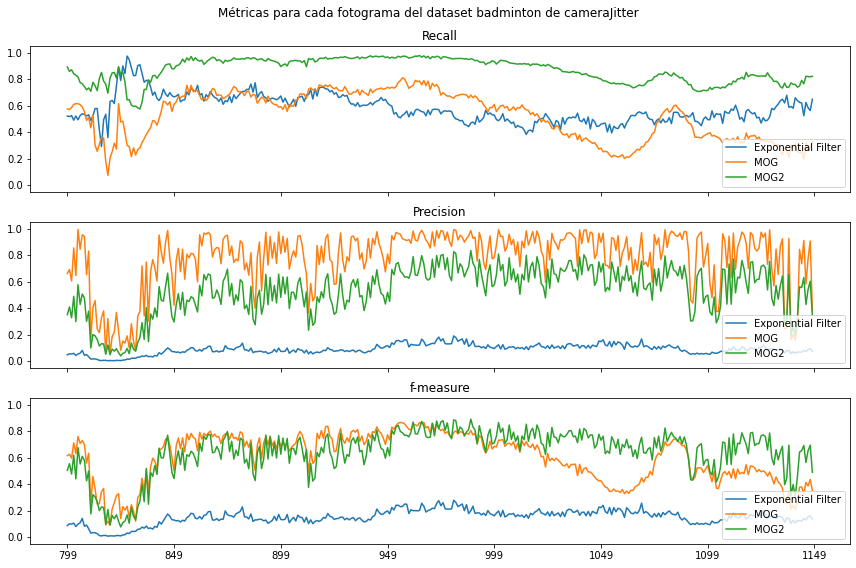

In [28]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(12,8))
ax[0].plot(r_p_fm_frames_EF[0], label="Exponential Filter")
ax[0].plot(r_p_fm_frames_MOG[0],label="MOG")
ax[0].plot(r_p_fm_frames_MOG2[0],label="MOG2")
ax[0].set_title("Recall")

locs, labels = plt.xticks()
my_ticks = np.zeros(len(locs))
for i in range(len(locs)):
    my_ticks[i] = int(locs[i]+799)
    
my_ticks = my_ticks.astype(int)

plt.xticks(locs[1:-1], my_ticks[1:-1])


ax[1].plot(r_p_fm_frames_EF[1],label="Exponential Filter")
ax[1].plot(r_p_fm_frames_MOG[1],label="MOG")
ax[1].plot(r_p_fm_frames_MOG2[1],label="MOG2")
ax[1].set_title("Precision")
plt.xticks(locs[1:-1], my_ticks[1:-1])

ax[2].plot(r_p_fm_frames_EF[2],label="Exponential Filter")
ax[2].plot(r_p_fm_frames_MOG[2],label="MOG")
ax[2].plot(r_p_fm_frames_MOG2[2],label="MOG2")
ax[2].set_title("f-measure")
plt.xticks(locs[1:-1], my_ticks[1:-1])



plt.ylim([-0.05,1.05])
legend = ax[0].legend(loc='lower right')
legend = ax[1].legend(loc='lower right')
legend = ax[2].legend(loc='lower right')
fig.suptitle('Métricas para cada fotograma del dataset badminton de cameraJitter')
fig.tight_layout()
plt.show()

En este caso obtenemos resultado similares, pero el algoritmo basado en filtro exponencial obtiene resultados aun peores. Aquí se observa, más claramente, que el algoritmo MOG nos proporciona mejor precisión que MOG2. Como ya se ha comentado, MOG consigue mejores resultados que MOG2 en entornos con ruido y en este caso se trata de una secuencia cuya camara vibra durante la grabación, lo que genera movimiento aparente en la imagen. Observando los resultados en video, el filtro exponencial detecta prácticamente todas las lineas del suelo del campo de badminton como _foreground_ incorrectamente, esto puede ser debido a que el ratio de aprendizaje del filtro sea muy bajo, aumentando el ratio el algoritmo podría actualizar más rápidamente el _background_ y conseguir mejores resultados, pero el objetivo es comprobar el comportamiento del algoritmo para diferentes situaciones. A pesar de que para un problema en concreto se suele ajustar el algoritmo a medida.

In [29]:
EF_result = loadImages(expFilter_badminton_path+'*.png')
MOG_result = loadImages(MOG_badminton_path+'*.png')
MOG2_result = loadImages(MOG2_badminton_path+'*.png')

Loading images: 100%|█████████████████████████████████████████████████████████████| 1150/1150 [00:02<00:00, 566.34it/s]


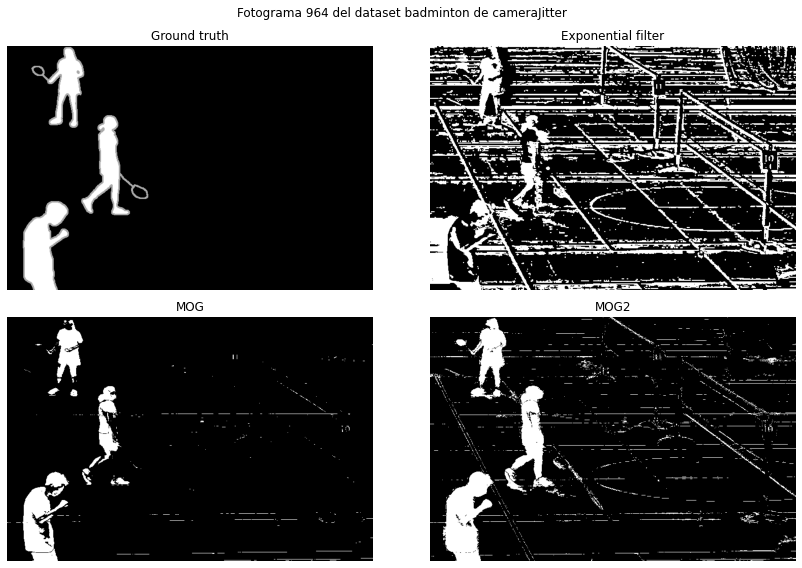

In [30]:
frame = 963
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,8))
ax[0,0].imshow(groundTruth[frame])
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')

ax[0,1].imshow(EF_result[frame])
ax[0,1].axis('off')
ax[0,1].set_title('Exponential filter')


ax[1,0].imshow(MOG_result[frame])
ax[1,0].axis('off')
ax[1,0].set_title('MOG')

ax[1,1].imshow(MOG2_result[frame])
ax[1,1].axis('off')
ax[1,1].set_title('MOG2')


fig.suptitle('Fotograma '+ str(frame+1) + ' del dataset badminton de cameraJitter')
fig.tight_layout()
plt.show()

En la imagen anterior, se puede comprobar que el filtro exponencial detecta casi toda la imagen como _foreground_ y que MOG es el que más se acera al resultado esperado.

In [31]:
df_badminton = pd.DataFrame(np.array([np.concatenate((r_p_fm_secuencia_EF,cm_secuencia_EF)),
                                    np.concatenate((r_p_fm_secuencia_MOG,cm_secuencia_MOG)),
                                    np.concatenate((r_p_fm_secuencia_MOG2,cm_secuencia_MOG2)),
                                    np.concatenate((r_p_fm_secuencia_gt,cm_secuencia_gt))]),
                         columns = ['Recall', 'Precision','F-measure','TP','FP','FN','TN'])
df_badminton['Algorithm'] = ['Exponential Filter','MOG','MOG2','Ground truth']
df_badminton.set_index('Algorithm')

,Recall,Precision,F-measure,TP,FP,FN,TN
Algorithm,,,,,,,
Exponential Filter,0.553958,0.086782,0.150057,2736812.0,28799701.0,2203658.0,87219829.0
MOG,0.537297,0.797374,0.641996,2402273.0,610456.0,2068760.0,115878511.0
MOG2,0.881480,0.544809,0.673409,4505616.0,3764470.0,605806.0,112084108.0
Ground truth,1.000000,1.000000,1.000000,4087403.0,0.0,0.0,115099628.0


# 3. Secuencia _canoe_ del dataset _dynamicBackground_

Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [32]:
# dynamicBackground  canoe dataset input
gt_canoe_path = 'DATA/dynamicBackground/dynamicBackground/canoe/groundtruth/*.png'
in_canoe_path = 'DATA/dynamicBackground/dynamicBackground/canoe/input/*.jpg'

groundTruth = loadImages(gt_canoe_path)
frames = loadImages(in_canoe_path)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1189/1189 [00:01<00:00, 771.28it/s]


## 3.1. Algoritmo filtro exponencial

In [33]:
# dynamicBackground canoe dataset output paths
expFilter_canoe_path = 'DATA/dynamicBackground/results/canoe/expFilter/'

exponentialFilter(frames, 0.3, expFilter_canoe_path, 20, bgFilter ='MEDIAN')

Algorithm application: 100%|██████████████████████████████████████████████████████| 1169/1169 [00:01<00:00, 705.59it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [34]:
im2vid(expFilter_canoe_path+'*.png','expFilter_canoe.mp4')
#showVideo('expFilter_canoe.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 1690.06it/s]


### 3.1.1 Cálculo de métricas

In [35]:
cm_frames_EF,\
cm_secuencia_EF,\
r_p_fm_frames_EF,\
r_p_fm_secuencia_RF = all_metrics (expFilter_canoe_path+'*.png', gt_canoe_path, start_frame=799, end_frame=1188)

Loading images: 100%|████████████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 2569.20it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## 3.2. Algoritmo MOG

In [36]:
# dynamicBackground canoe dataset output path
MOG_canoe_path = 'DATA/dynamicBackground/results/canoe/MOG/'

MOG(frames, MOG_canoe_path)

Algorithm application2: 100%|█████████████████████████████████████████████████████| 1189/1189 [00:02<00:00, 491.51it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [37]:
im2vid(MOG_canoe_path+'*.png','MOG_canoe.mp4')
#showVideo('MOG_canoe.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 2232.56it/s]


### 3.2.1 Cálculo de métricas

In [38]:
cm_frames_MOG,\
cm_secuencia_MOG,\
r_p_fm_frames_MOG,\
r_p_fm_secuencia_MOG = all_metrics (MOG_canoe_path+'*.png', gt_canoe_path, start_frame=799, end_frame=1188)

Loading images: 100%|████████████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 2574.74it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## 3.3. Algoritmo MOG2

In [39]:
# dynamicBackground canoe dataset output path
MOG2_canoe_path = 'DATA/dynamicBackground/results/canoe/MOG2/'

MOG2(frames, MOG2_canoe_path)

Algorithm application: 100%|██████████████████████████████████████████████████████| 1189/1189 [00:03<00:00, 364.81it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [40]:
im2vid(MOG2_canoe_path+'*.png','MOG2_canoe.mp4')
#showVideo('MOG2_canoe.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 1768.81it/s]


### 3.3.1. Cálculo de métricas

In [41]:
cm_frames_MOG2,\
cm_secuencia_MOG2,\
r_p_fm_frames_MOG2,\
r_p_fm_secuencia_MOG2 = all_metrics (MOG2_canoe_path +'*.png', gt_canoe_path, start_frame=799, end_frame=1188)

Loading images: 100%|████████████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 2614.26it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## 3.4. Comparación resultados

In [42]:
cm_frames_gt,\
cm_secuencia_gt,\
r_p_fm_frames_gt,\
r_p_fm_secuencia_gt = all_metrics (gt_canoe_path, gt_canoe_path, start_frame=799, end_frame=1188)

Loading images: 100%|████████████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 2649.12it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


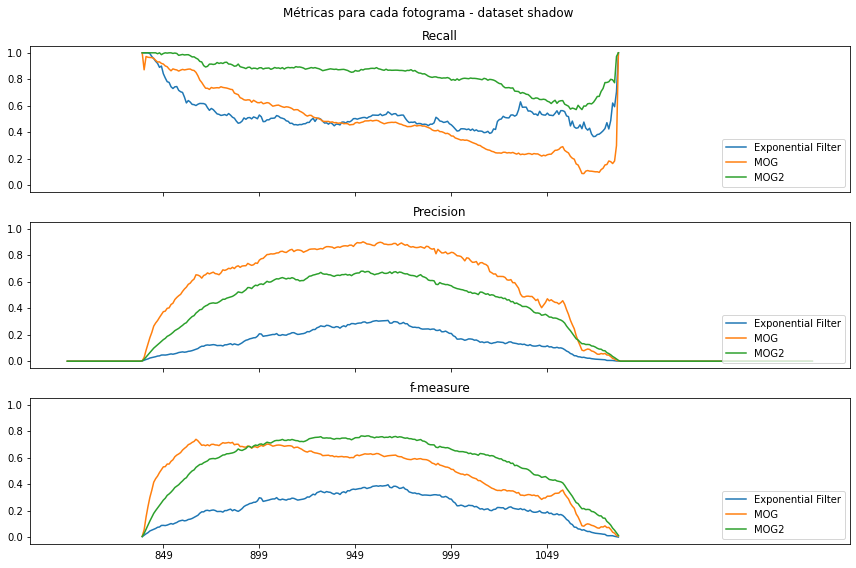

In [43]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(12,8))
ax[0].plot(r_p_fm_frames_EF[0], label="Exponential Filter")
ax[0].plot(r_p_fm_frames_MOG[0],label="MOG")
ax[0].plot(r_p_fm_frames_MOG2[0],label="MOG2")
ax[0].set_title("Recall")

locs, labels = plt.xticks()
my_ticks = np.zeros(len(locs))
for i in range(len(locs)):
    my_ticks[i] = int(locs[i]+799)
    
my_ticks = my_ticks.astype(int)

plt.xticks(locs[1:-1], my_ticks[1:-1])


ax[1].plot(r_p_fm_frames_EF[1],label="Exponential Filter")
ax[1].plot(r_p_fm_frames_MOG[1],label="MOG")
ax[1].plot(r_p_fm_frames_MOG2[1],label="MOG2")
ax[1].set_title("Precision")
plt.xticks(locs[1:-1], my_ticks[1:-1])

ax[2].plot(r_p_fm_frames_EF[2],label="Exponential Filter")
ax[2].plot(r_p_fm_frames_MOG[2],label="MOG")
ax[2].plot(r_p_fm_frames_MOG2[2],label="MOG2")
ax[2].set_title("f-measure")
plt.xticks(locs[1:-1], my_ticks[1:-1])



plt.ylim([-0.05,1.05])
legend = ax[0].legend(loc='lower right')
legend = ax[1].legend(loc='lower right')
legend = ax[2].legend(loc='lower right')
fig.suptitle('Métricas para cada fotograma - dataset shadow')
fig.tight_layout()
plt.show()

En este caso tenemos una situación muy similar a la anterior, esta vez el ruido no está provocado por el movimiento de la cámara sino por las perturbaciones del agua. Se observa que para los primero y últimos fotogramas obtenemos una precision y f-measure de 0, esto es porque el resultado esperado es que no se detecte el movimiento del agua sino únicamente la canoa que cruza.

In [44]:
EF_result = loadImages(expFilter_canoe_path+'*.png')
MOG_result = loadImages(MOG_canoe_path+'*.png')
MOG2_result = loadImages(MOG2_canoe_path+'*.png')

Loading images: 100%|████████████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 1730.23it/s]


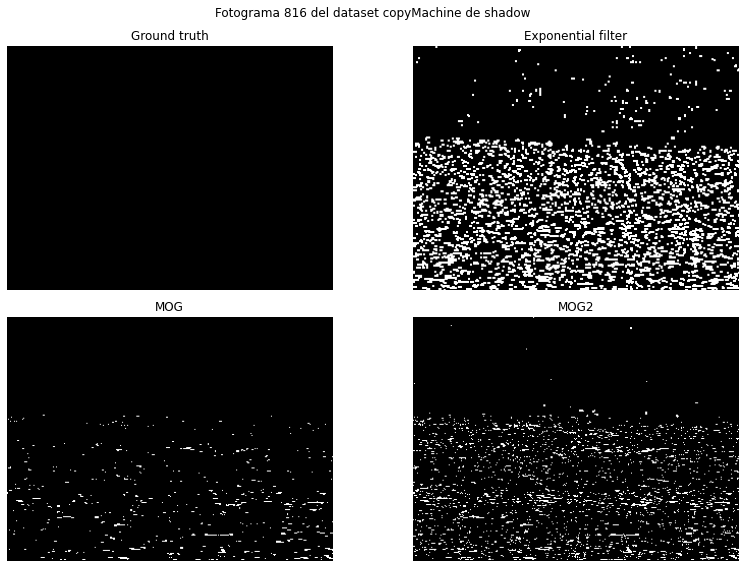

In [45]:
frame = 815
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,8))
ax[0,0].imshow(groundTruth[frame])
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')

ax[0,1].imshow(EF_result[frame])
ax[0,1].axis('off')
ax[0,1].set_title('Exponential filter')


ax[1,0].imshow(MOG_result[frame])
ax[1,0].axis('off')
ax[1,0].set_title('MOG')

ax[1,1].imshow(MOG2_result[frame])
ax[1,1].axis('off')
ax[1,1].set_title('MOG2')


fig.suptitle('Fotograma '+ str(frame+1) + ' del dataset copyMachine de shadow')
fig.tight_layout()
plt.show()

In [46]:
df_canoe = pd.DataFrame(np.array([np.concatenate((r_p_fm_secuencia_EF,cm_secuencia_EF)),
                                    np.concatenate((r_p_fm_secuencia_MOG,cm_secuencia_MOG)),
                                    np.concatenate((r_p_fm_secuencia_MOG2,cm_secuencia_MOG2)),
                                    np.concatenate((r_p_fm_secuencia_gt,cm_secuencia_gt))]),
                         columns = ['Recall', 'Precision','F-measure','TP','FP','FN','TN'])
df_canoe['Algorithm'] = ['Exponential Filter','MOG','MOG2','Ground truth']
df_canoe.set_index('Algorithm')

,Recall,Precision,F-measure,TP,FP,FN,TN
Algorithm,,,,,,,
Exponential Filter,0.553958,0.086782,0.150057,617810.0,5292561.0,623364.0,23341465.0
MOG,0.467723,0.610834,0.529784,537578.0,342494.0,611772.0,28383356.0
MOG2,0.841505,0.406955,0.548604,1087033.0,1584102.0,204740.0,26999325.0
Ground truth,1.000000,1.000000,1.000000,1043369.0,0.0,0.0,28342921.0


# 4. Secuencia _sofa_ del dataset _intermittentObjectMotion_

Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [47]:
# intermittentObjectMotion sofa dataset input
gt_sofa_path = 'DATA/intermittentObjectMotion/intermittentObjectMotion/sofa/groundtruth/*.png'
in_sofa_path = 'DATA/intermittentObjectMotion/intermittentObjectMotion/sofa/input/*.jpg'

groundTruth = loadImages(gt_sofa_path)
frames = loadImages(in_sofa_path)

Loading images: 100%|█████████████████████████████████████████████████████████████| 2750/2750 [00:03<00:00, 806.72it/s]


## 4.1. Algoritmo filtro exponencial

In [48]:
# intermittentObjectMotion sofa dataset output path
expFilter_sofa_path = 'DATA/intermittentObjectMotion/results/sofa/expFilter/'

exponentialFilter(frames, 0.3, expFilter_sofa_path, 20, bgFilter ='MEDIAN')

Algorithm application: 100%|██████████████████████████████████████████████████████| 2730/2730 [00:02<00:00, 995.79it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [49]:
im2vid(expFilter_sofa_path+'*.png','expFilter_sofa.mp4')
#showVideo('expFilter_sofa.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 2750/2750 [00:00<00:00, 2866.19it/s]


### 4.1.1. Cálculo de métricas

In [50]:
cm_frames_EF,\
cm_secuencia_EF,\
r_p_fm_frames_EF,\
r_p_fm_secuencia_EF = all_metrics (expFilter_sofa_path+'*.png', gt_sofa_path, start_frame=499, end_frame=2749)

Loading images: 100%|████████████████████████████████████████████████████████████| 2750/2750 [00:01<00:00, 2352.63it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## 4.2. Algoritmo MOG

In [51]:
# intermittentObjectMotion sofa dataset output path
MOG_sofa_path = 'DATA/intermittentObjectMotion/results/sofa/MOG/'

MOG(frames,MOG_sofa_path)

Algorithm application2: 100%|█████████████████████████████████████████████████████| 2750/2750 [00:05<00:00, 499.73it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [52]:
im2vid(MOG_sofa_path+'*.png','MOG_sofa.mp4')
#showVideo('MOG_sofa.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 2750/2750 [00:00<00:00, 4520.25it/s]


### 4.2.1. Cálculo de métricas

In [53]:
cm_frames_MOG,\
cm_secuencia_MOG,\
r_p_fm_frames_MOG,\
r_p_fm_secuencia_MOG = all_metrics (MOG_sofa_path+'*.png', gt_sofa_path, start_frame=499, end_frame=2749)

Loading images: 100%|████████████████████████████████████████████████████████████| 2750/2750 [00:01<00:00, 2368.86it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


## 4.3. Algoritmo MOG2

In [54]:
# intermittentObjectMotion sofa dataset output path
MOG2_sofa_path = 'DATA/intermittentObjectMotion/results/sofa/MOG2/'

MOG2(frames,MOG2_sofa_path)

Algorithm application: 100%|██████████████████████████████████████████████████████| 2750/2750 [00:05<00:00, 546.67it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [55]:
im2vid(MOG2_sofa_path+'*.png','MOG2_sofa.mp4')
#showVideo('MOG2_sofa.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 2750/2750 [00:00<00:00, 4048.98it/s]


### 4.3.1. Cálculo de métricas

In [56]:
cm_frames_MOG2,\
cm_secuencia_MOG2,\
r_p_fm_frames_MOG2,\
r_p_fm_secuencia_MOG2 = all_metrics (MOG2_sofa_path+'*.png', gt_sofa_path, start_frame=499, end_frame=2749)

Loading images: 100%|████████████████████████████████████████████████████████████| 2750/2750 [00:01<00:00, 2383.19it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## 4.4. Comparación resultados

In [57]:
cm_frames_gt,\
cm_secuencia_gt,\
r_p_fm_frames_gt,\
r_p_fm_secuencia_gt = all_metrics (gt_sofa_path, gt_sofa_path, start_frame=499, end_frame=2749)

Loading images: 100%|████████████████████████████████████████████████████████████| 2750/2750 [00:01<00:00, 2381.08it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


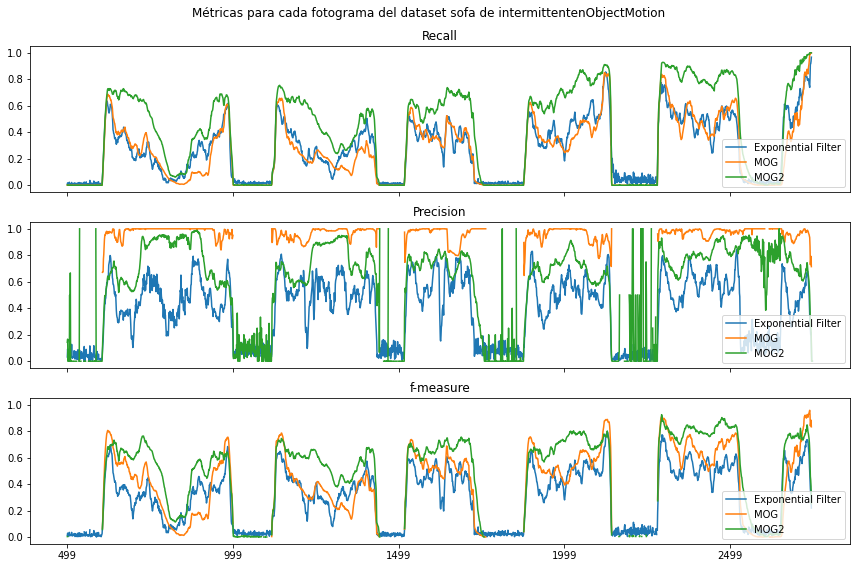

In [58]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(12,8))
ax[0].plot(r_p_fm_frames_EF[0], label="Exponential Filter")
ax[0].plot(r_p_fm_frames_MOG[0],label="MOG")
ax[0].plot(r_p_fm_frames_MOG2[0],label="MOG2")
ax[0].set_title("Recall")

locs, labels = plt.xticks()
my_ticks = np.zeros(len(locs))
for i in range(len(locs)):
    my_ticks[i] = int(locs[i]+499)
    
my_ticks = my_ticks.astype(int)

plt.xticks(locs[1:-1], my_ticks[1:-1])


ax[1].plot(r_p_fm_frames_EF[1],label="Exponential Filter")
ax[1].plot(r_p_fm_frames_MOG[1],label="MOG")
ax[1].plot(r_p_fm_frames_MOG2[1],label="MOG2")
ax[1].set_title("Precision")
plt.xticks(locs[1:-1], my_ticks[1:-1])

ax[2].plot(r_p_fm_frames_EF[2],label="Exponential Filter")
ax[2].plot(r_p_fm_frames_MOG[2],label="MOG")
ax[2].plot(r_p_fm_frames_MOG2[2],label="MOG2")
ax[2].set_title("f-measure")
plt.xticks(locs[1:-1], my_ticks[1:-1])



plt.ylim([-0.05,1.05])
legend = ax[0].legend(loc='lower right')
legend = ax[1].legend(loc='lower right')
legend = ax[2].legend(loc='lower right')
fig.suptitle('Métricas para cada fotograma del dataset sofa de intermittentenObjectMotion')
fig.tight_layout()
plt.show()

En este caso nos encontramos que los algoritmos no consiguen seguir manteniendo como _foreground_ aquellos objetos que han entrado en escena, se han parado y al cado de un rato vuelven a ponerse en movimiento. Más o menos el comportamiento de los modelos es muy parecido. Cabe destacar que MOG2 consigue mejores resultados en general.

In [59]:
EF_result = loadImages(expFilter_sofa_path+'*.png')
MOG_result = loadImages(MOG_sofa_path+'*.png')
MOG2_result = loadImages(MOG2_sofa_path+'*.png')

Loading images: 100%|████████████████████████████████████████████████████████████| 2750/2750 [00:01<00:00, 2022.96it/s]


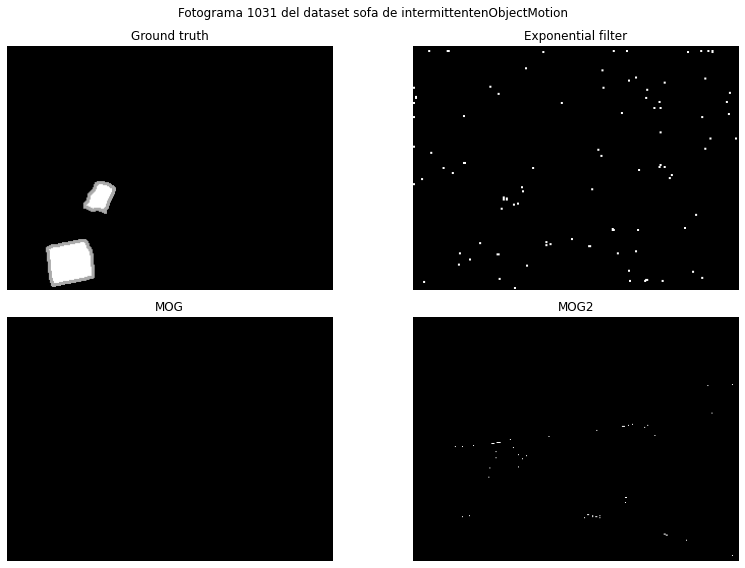

In [60]:
frame = 1030
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,8))
ax[0,0].imshow(groundTruth[frame])
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')

ax[0,1].imshow(EF_result[frame])
ax[0,1].axis('off')
ax[0,1].set_title('Exponential filter')


ax[1,0].imshow(MOG_result[frame])
ax[1,0].axis('off')
ax[1,0].set_title('MOG')

ax[1,1].imshow(MOG2_result[frame])
ax[1,1].axis('off')
ax[1,1].set_title('MOG2')


fig.suptitle('Fotograma '+ str(frame+1) + ' del dataset sofa de intermittentenObjectMotion')
fig.tight_layout()
plt.show()

En la imagen anterior se observa que el resultado esperado de los algoritmos sea que detecten el objeto parado como _foreground_ pero ninguno lo consigue.

In [61]:
df_sofa = pd.DataFrame(np.array([np.concatenate((r_p_fm_secuencia_EF,cm_secuencia_EF)),
                                    np.concatenate((r_p_fm_secuencia_MOG,cm_secuencia_MOG)),
                                    np.concatenate((r_p_fm_secuencia_MOG2,cm_secuencia_MOG2)),
                                    np.concatenate((r_p_fm_secuencia_gt,cm_secuencia_gt))]),
                         columns = ['Recall', 'Precision','F-measure','TP','FP','FN','TN'])
df_sofa['Algorithm'] = ['Exponential Filter','MOG','MOG2','Ground truth']
df_sofa.set_index('Algorithm')

,Recall,Precision,F-measure,TP,FP,FN,TN
Algorithm,,,,,,,
Exponential Filter,0.331614,0.496447,0.397624,2697263.0,2735873.0,5436489.0,161930375.0
MOG,0.319962,0.960927,0.480073,2548262.0,103618.0,5416010.0,164732110.0
MOG2,0.543489,0.715990,0.617927,4695011.0,1862363.0,3943631.0,162298995.0
Ground truth,1.000000,1.000000,1.000000,7388680.0,0.0,0.0,161752098.0


# 5. Secuencia _copyMachine_ del dataset _shadow_

Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [62]:
# shadow copyMachine dataset input
gt_copyMachine_path = 'DATA/shadow/shadow/copyMachine/groundtruth/*.png'
in_copyMachine_path = 'DATA/shadow/shadow/copyMachine/input/*.jpg'

groundTruth = loadImages(gt_copyMachine_path)
frames = loadImages(in_copyMachine_path)

Loading images: 100%|█████████████████████████████████████████████████████████████| 3400/3400 [00:17<00:00, 194.40it/s]


## 5.1. Algoritmo filtro exponencial

In [63]:
# shadow copyMachine dataset output path
expFilter_copyMachine_path = 'DATA/shadow/results/copyMachine/expFilter/'

exponentialFilter(frames, 0.3, expFilter_copyMachine_path, 20, bgFilter ='MEDIAN')

Algorithm application: 100%|██████████████████████████████████████████████████████| 3380/3380 [00:24<00:00, 140.21it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [64]:
im2vid(expFilter_copyMachine_path+'*.png','expFilter_copyMachine.mp4')
#showVideo('expFilter_copyMachine.mp4')

Converting to video: 100%|████████████████████████████████████████████████████████| 3400/3400 [00:09<00:00, 366.98it/s]


### 5.1.1. Cálculo de métricas

In [65]:
cm_frames_EF,\
cm_secuencia_EF,\
r_p_fm_frames_EF,\
r_p_fm_secuencia_EF = all_metrics (expFilter_copyMachine_path+'*.png', gt_copyMachine_path, start_frame=499, end_frame=3399)

Loading images: 100%|█████████████████████████████████████████████████████████████| 3400/3400 [00:08<00:00, 387.33it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## 5.2. Algoritmo MOG

In [66]:
# shadow copyMachine dataset output path
MOG_copyMachine_path = 'DATA/shadow/results/copyMachine/MOG/'

MOG(frames, MOG_copyMachine_path)

Algorithm application2: 100%|█████████████████████████████████████████████████████| 3400/3400 [00:33<00:00, 100.18it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [67]:
im2vid(MOG_copyMachine_path+'*.png','MOG_copyMachine.mp4')
#showVideo('MOG_copyMachine.mp4')

Converting to video: 100%|████████████████████████████████████████████████████████| 3400/3400 [00:03<00:00, 943.12it/s]


### 5.2.1. Cálculo de métricas

In [68]:
cm_frames_MOG,\
cm_secuencia_MOG,\
r_p_fm_frames_MOG,\
r_p_fm_secuencia_MOG = all_metrics (MOG_copyMachine_path+'*.png', gt_copyMachine_path, start_frame=499, end_frame=3399)

Loading images: 100%|█████████████████████████████████████████████████████████████| 3400/3400 [00:09<00:00, 374.57it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## 5.3. Algoritmo MOG2

In [69]:
# shadow copyMachine dataset output path
MOG2_copyMachine_path = 'DATA/shadow/results/copyMachine/MOG2/'

MOG2(frames, MOG2_copyMachine_path)

Algorithm application: 100%|██████████████████████████████████████████████████████| 3400/3400 [00:15<00:00, 219.91it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado y mostramos el video en una ventana flotante.

In [70]:
im2vid(MOG2_copyMachine_path+'*.png','MOG2_copyMachine.mp4')
#showVideo('MOG2_copyMachine.mp4')

Converting to video: 100%|████████████████████████████████████████████████████████| 3400/3400 [00:04<00:00, 804.14it/s]


### 5.3.1. Cálculo de métricas

In [71]:
cm_frames_MOG2,\
cm_secuencia_MOG2,\
r_p_fm_frames_MOG2,\
r_p_fm_secuencia_MOG2 = all_metrics (MOG2_copyMachine_path+'*.png', gt_copyMachine_path, start_frame=499, end_frame=3399)

Loading images: 100%|█████████████████████████████████████████████████████████████| 3400/3400 [00:09<00:00, 365.63it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## 5.4. Comparación resultados

In [72]:
cm_frames_gt,\
cm_secuencia_gt,\
r_p_fm_frames_gt,\
r_p_fm_secuencia_gt = all_metrics (gt_copyMachine_path, gt_copyMachine_path, start_frame=499, end_frame=3399)

Loading images: 100%|█████████████████████████████████████████████████████████████| 3400/3400 [00:04<00:00, 698.30it/s]
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\visio_per_computador\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


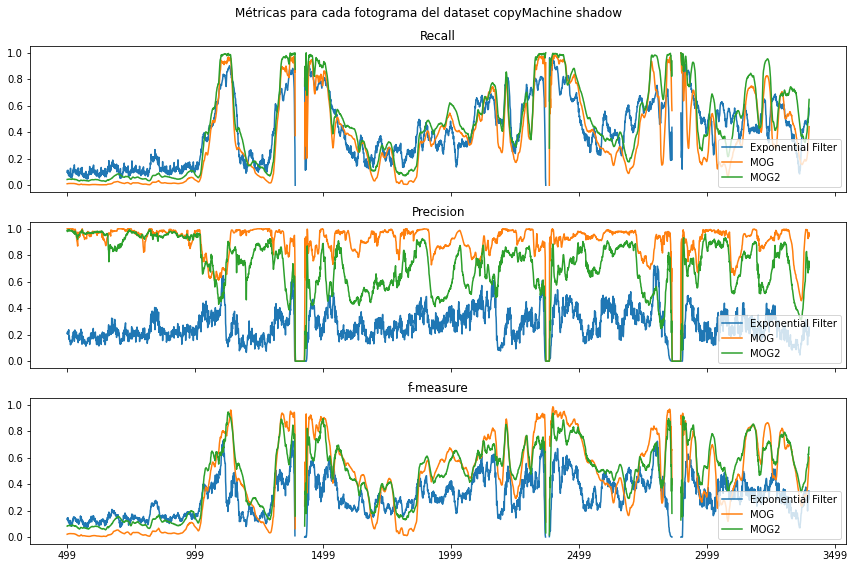

In [73]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(12,8))
ax[0].plot(r_p_fm_frames_EF[0], label="Exponential Filter")
ax[0].plot(r_p_fm_frames_MOG[0],label="MOG")
ax[0].plot(r_p_fm_frames_MOG2[0],label="MOG2")
ax[0].set_title("Recall")

locs, labels = plt.xticks()
my_ticks = np.zeros(len(locs))
for i in range(len(locs)):
    my_ticks[i] = int(locs[i]+499)
    
my_ticks = my_ticks.astype(int)

plt.xticks(locs[1:-1], my_ticks[1:-1])


ax[1].plot(r_p_fm_frames_EF[1],label="Exponential Filter")
ax[1].plot(r_p_fm_frames_MOG[1],label="MOG")
ax[1].plot(r_p_fm_frames_MOG2[1],label="MOG2")
ax[1].set_title("Precision")
plt.xticks(locs[1:-1], my_ticks[1:-1])

ax[2].plot(r_p_fm_frames_EF[2],label="Exponential Filter")
ax[2].plot(r_p_fm_frames_MOG[2],label="MOG")
ax[2].plot(r_p_fm_frames_MOG2[2],label="MOG2")
ax[2].set_title("f-measure")
plt.xticks(locs[1:-1], my_ticks[1:-1])



plt.ylim([-0.05,1.05])
legend = ax[0].legend(loc='lower right')
legend = ax[1].legend(loc='lower right')
legend = ax[2].legend(loc='lower right')
fig.suptitle('Métricas para cada fotograma del dataset copyMachine shadow')
fig.tight_layout()
plt.show()

En esta última secuencia, se comprueba cómo se comportan los algoritmos en entornos con sombras y cambios de iluminación. La secuencia consta de una pequeña habitación por la cual entra la luz por una ventana en la parte derecha. Cada vez que entra una persona la iluminación cambia y los algoritmos se deben ajustar a estos cambios. 

In [74]:
EF_result = loadImages(expFilter_copyMachine_path+'*.png')
MOG_result = loadImages(MOG_copyMachine_path+'*.png')
MOG2_result = loadImages(MOG2_copyMachine_path+'*.png')

Loading images: 100%|█████████████████████████████████████████████████████████████| 3400/3400 [00:25<00:00, 131.19it/s]


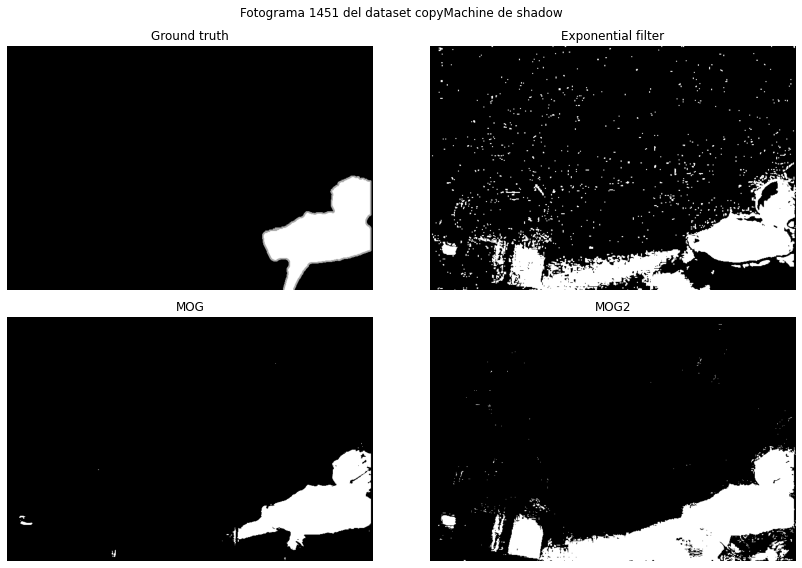

In [84]:
frame = 1450
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,8))
ax[0,0].imshow(groundTruth[frame])
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')

ax[0,1].imshow(EF_result[frame])
ax[0,1].axis('off')
ax[0,1].set_title('Exponential filter')


ax[1,0].imshow(MOG_result[frame])
ax[1,0].axis('off')
ax[1,0].set_title('MOG')

ax[1,1].imshow(MOG2_result[frame])
ax[1,1].axis('off')
ax[1,1].set_title('MOG2')


fig.suptitle('Fotograma '+ str(frame+1) + ' del dataset copyMachine de shadow')
fig.tight_layout()
plt.show()

In [79]:
df_copyMachine = pd.DataFrame(np.array([np.concatenate((r_p_fm_secuencia_EF,100*cm_secuencia_EF/sum(cm_secuencia_EF))),
                                    np.concatenate((r_p_fm_secuencia_MOG,100*cm_secuencia_MOG/sum(cm_secuencia_MOG))),
                                    np.concatenate((r_p_fm_secuencia_MOG2,100*cm_secuencia_MOG2/sum(cm_secuencia_MOG2))),
                                    np.concatenate((r_p_fm_secuencia_gt,100*cm_secuencia_gt/sum(cm_secuencia_gt)))]),
                         columns = ['Recall', 'Precision','F-measure','TP','FP','FN','TN'])
df_copyMachine['Algorithm'] = ['Exponential Filter','MOG','MOG2','Ground truth']
df_copyMachine.set_index('Algorithm')

,Recall,Precision,F-measure,TP,FP,FN,TN
Algorithm,,,,,,,
Exponential Filter,0.403568,0.270216,0.323696,2.912571,7.866109,4.304489,84.916831
MOG,0.354453,0.873907,0.504345,2.508680,0.361968,4.568934,92.560418
MOG2,0.435203,0.635021,0.516458,3.187765,1.832171,4.137015,90.843048
Ground truth,1.000000,1.000000,1.000000,6.929556,0.000000,0.000000,93.070444
